# A python implementation for the MLP
MLP code based on [Marsland (2014)](https://seat.massey.ac.nz/personal/s.r.marsland/MLbook.html)

Contains:
* 1. a perceptron class called **pcn**
* 2. a Multi-layer perceptron class called **mlp**
* 3. a test-case of the pcn
* 4. a test-case of mlp classification
* 5. an analytical testcase for mlp regression
* 6. classification with the Iris data set
* 7. classification with the MNIST data set


## 1. Perceptron class (PCN)

In [1]:
import numpy as np

class pcn:
    """ A basic Perceptron"""
    def __init__(self,inputs,targets):
        """ Constructor """
        # Set up network size
        if np.ndim(inputs)>1:
            self.nIn = np.shape(inputs)[1]
        else: 
            self.nIn = 1

        if np.ndim(targets)>1:
            self.nOut = np.shape(targets)[1]
        else:
            self.nOut = 1

        self.nData = np.shape(inputs)[0]

        # Initialise network
        self.weights = np.random.rand(self.nIn+1,self.nOut)*0.1-0.05

    def pcntrain(self,inputs,targets,eta,nIterations):
        """ Train the thing """	
        # Add the inputs that match the bias node
        inputs = np.concatenate((inputs,-np.ones((self.nData,1))),axis=1)
        # Training
        change = range(self.nData)

        for n in range(nIterations):
            self.activations = self.pcnfwd(inputs);
            self.weights -= eta*np.dot(np.transpose(inputs),self.activations-targets)
            
            #Randomise order of inputs
            #np.random.shuffle(change)
            #inputs = inputs[change,:]
            #targets = targets[change,:]

        #return self.weights

    def pcnfwd(self,inputs):
        """ Run the network forward """
        # Compute activations
        activations =  np.dot(inputs,self.weights)

        # Threshold the activations
        return np.where(activations>0,1,0)

    def confmat(self,inputs,targets):
        """Confusion matrix"""

        # Add the inputs that match the bias node
        inputs = np.concatenate((inputs,-np.ones((self.nData,1))),axis=1)

        outputs = np.dot(inputs,self.weights)

        nClasses = np.shape(targets)[1]

        if nClasses==1:
            nClasses = 2
            outputs = np.where(outputs>0,1,0)
        else:
            # 1-of-N encoding
            outputs = np.argmax(outputs,1)
            targets = np.argmax(targets,1)

        cm = np.zeros((nClasses,nClasses))
        for i in range(nClasses):
            for j in range(nClasses):
                cm[i,j] = np.sum(np.where(outputs==i,1,0)*np.where(targets==j,1,0))

        print(cm)
        print(np.trace(cm)/np.sum(cm))

def logic():
    import pcn
    """ Run AND and XOR logic functions"""

    a = np.array([[0,0,0],[0,1,0],[1,0,0],[1,1,1]])
    b = np.array([[0,0,0],[0,1,1],[1,0,1],[1,1,0]])

    p = pcn.pcn(a[:,0:2],a[:,2:])
    p.pcntrain(a[:,0:2],a[:,2:],0.25,10)
    p.confmat(a[:,0:2],a[:,2:])

    q = pcn.pcn(b[:,0:2],b[:,2:])
    q.pcntrain(b[:,0:2],b[:,2:],0.25,10)
    q.confmat(b[:,0:2],b[:,2:])


## 2. Multi-layer Perceptron class

In [2]:
class mlp:
    """ A Multi-Layer Perceptron"""
    
    def __init__(self,inputs,targets,nhidden,beta=1,momentum=0.9,outtype='logistic'):
        """ Constructor """
        # Set up network size
        self.nin = np.shape(inputs)[1]
        self.nout = np.shape(targets)[1]
        self.ndata = np.shape(inputs)[0]
        self.nhidden = nhidden

        self.beta = beta
        self.momentum = momentum
        self.outtype = outtype
    
        # Initialise network
        self.weights1 = (np.random.rand(self.nin+1,self.nhidden)-0.5)*2/np.sqrt(self.nin)
        self.weights2 = (np.random.rand(self.nhidden+1,self.nout)-0.5)*2/np.sqrt(self.nhidden)

    def earlystopping(self,inputs,targets,valid,validtargets,eta,niterations=100):
    
        valid = np.concatenate((valid,-np.ones((np.shape(valid)[0],1))),axis=1)
        
        old_val_error1 = 100002
        old_val_error2 = 100001
        new_val_error = 100000
        
        count = 0
        while (((old_val_error1 - new_val_error) > 0.001) or ((old_val_error2 - old_val_error1)>0.001)):
            count+=1
            print(count)
            self.mlptrain(inputs,targets,eta,niterations)
            old_val_error2 = old_val_error1
            old_val_error1 = new_val_error
            validout = self.mlpfwd(valid)
            new_val_error = 0.5*np.sum((validtargets-validout)**2)
            
        print("Stopped", new_val_error,old_val_error1, old_val_error2)
        return new_val_error
    
    def mlptrain(self,inputs,targets,eta,niterations):
        """ Train the thing """    
        # Add the inputs that match the bias node
        inputs = np.concatenate((inputs,-np.ones((self.ndata,1))),axis=1)
        change = range(self.ndata)
    
        updatew1 = np.zeros((np.shape(self.weights1)))
        updatew2 = np.zeros((np.shape(self.weights2)))
            
        for n in range(niterations):
    
            self.outputs = self.mlpfwd(inputs)

            error = 0.5*np.sum((self.outputs-targets)**2)
            if (np.mod(n,100)==0):
                print("Iteration: ",n, " Error: ",error)    

            # Different types of output neurons
            if self.outtype == 'linear':
            	deltao = (self.outputs-targets)/self.ndata
            elif self.outtype == 'logistic':
            	deltao = self.beta*(self.outputs-targets)*self.outputs*(1.0-self.outputs)
            elif self.outtype == 'softmax':
                deltao = (self.outputs-targets)*(self.outputs*(-self.outputs)+self.outputs)/self.ndata 
            else:
            	print("error")
            
            deltah = self.hidden*self.beta*(1.0-self.hidden)*(np.dot(deltao,np.transpose(self.weights2)))
                      
            updatew1 = eta*(np.dot(np.transpose(inputs),deltah[:,:-1])) + self.momentum*updatew1
            updatew2 = eta*(np.dot(np.transpose(self.hidden),deltao)) + self.momentum*updatew2
            self.weights1 -= updatew1
            self.weights2 -= updatew2
                
            # Randomise order of inputs (not necessary for matrix-based calculation)
            #np.random.shuffle(change)
            #inputs = inputs[change,:]
            #targets = targets[change,:]
            
    def mlpfwd(self,inputs):
        """ Run the network forward """

        self.hidden = np.dot(inputs,self.weights1);
        self.hidden = 1.0/(1.0+np.exp(-self.beta*self.hidden))
        self.hidden = np.concatenate((self.hidden,-np.ones((np.shape(inputs)[0],1))),axis=1)

        outputs = np.dot(self.hidden,self.weights2);

        # Different types of output neurons
        if self.outtype == 'linear':
        	return outputs
        elif self.outtype == 'logistic':
            return 1.0/(1.0+np.exp(-self.beta*outputs))
        elif self.outtype == 'softmax':
            normalisers = np.sum(np.exp(outputs),axis=1)*np.ones((1,np.shape(outputs)[0]))
            return np.transpose(np.transpose(np.exp(outputs))/normalisers)
        else:
            print("error")

    def confmat(self,inputs,targets):
        """Confusion matrix"""

        # Add the inputs that match the bias node
        inputs = np.concatenate((inputs,-np.ones((np.shape(inputs)[0],1))),axis=1)
        outputs = self.mlpfwd(inputs)
        
        nclasses = np.shape(targets)[1]

        if nclasses==1:
            nclasses = 2
            outputs = np.where(outputs>0.5,1,0)
        else:
            # 1-of-N encoding
            outputs = np.argmax(outputs,1)
            targets = np.argmax(targets,1)

        cm = np.zeros((nclasses,nclasses))
        for i in range(nclasses):
            for j in range(nclasses):
                cm[i,j] = np.sum(np.where(outputs==i,1,0)*np.where(targets==j,1,0))

        print("Confusion matrix is:")
        print(cm)
        print("Percentage Correct: ",np.trace(cm)/np.sum(cm)*100)

## 3. Test the perceptron with the simple OR data-set 

In [3]:
import pcn

inputs = np.array([[0,0],[0,1],[1,0],[1,1]])
targets = np.array([[0],[1],[1],[1]])
p = pcn.pcn(inputs,targets)
p.pcntrain(inputs,targets,0.25,6)
p.confmat(inputs,targets)

[[1. 0.]
 [0. 3.]]
1.0


## 4. Test the MLP with logical functions

In [4]:
import mlp

anddata = np.array([[0,0,0],[0,1,0],[1,0,0],[1,1,1]])
xordata = np.array([[0,0,0],[0,1,1],[1,0,1],[1,1,0]])

p = mlp.mlp(anddata[:,0:2],anddata[:,2:3],2)
p.mlptrain(anddata[:,0:2],anddata[:,2:3],0.25,1001)
p.confmat(anddata[:,0:2],anddata[:,2:3])

q = mlp.mlp(xordata[:,0:2],xordata[:,2:3],2,outtype='logistic')
q.mlptrain(xordata[:,0:2],xordata[:,2:3],0.25,5001)
q.confmat(xordata[:,0:2],xordata[:,2:3])

Iteration:  0  Error:  0.46449245317446897
Iteration:  100  Error:  0.020625839612010782
Iteration:  200  Error:  0.003613402987626792
Iteration:  300  Error:  0.0019225909032347176
Iteration:  400  Error:  0.0012871723191536775
Iteration:  500  Error:  0.0009587684844731371
Iteration:  600  Error:  0.0007597758888041256
Iteration:  700  Error:  0.0006269641505217893
Iteration:  800  Error:  0.0005323501778460337
Iteration:  900  Error:  0.00046170127394946957
Iteration:  1000  Error:  0.00040703694439871824
Confusion matrix is:
[[3. 0.]
 [0. 1.]]
Percentage Correct:  100.0
Iteration:  0  Error:  0.5017038910552172
Iteration:  100  Error:  0.4999726219722284
Iteration:  200  Error:  0.4999286474412781
Iteration:  300  Error:  0.49983597203741026
Iteration:  400  Error:  0.49957484352889414
Iteration:  500  Error:  0.4983848748641658
Iteration:  600  Error:  0.4846234728290525
Iteration:  700  Error:  0.09029584767905764
Iteration:  800  Error:  0.01159433924790552
Iteration:  900  Erro

* The first thing that we can do is check that this MLP can indeed learn the logic functions, especially the XOR. 

* There are a few things to notice about this. 


* One is that it does work, producing the correct answers, but the other is that even for the AND we need significantly more iterations than we did for the Perceptron. 

* So the benefits of a more complex network come at a cost, because it takes substantially more computational time to fit those weights to solve the problem, even for linear examples. 

* Sometimes, even 5000 iterations are not enough for the XOR function, and more have to be added.

## 5. A simple regression problem

* The regression problem we will look at is a very simple one. 

* We will take a set of samples generated by a simple mathematical function, and try to learn the generating function (that describes how the data was made) so that we can find the values of any inputs, not just the ones we have training data for.

* The function that we will use is a very simple one, just a bit of a sine wave. 

* Before getting started, we need to normalize the data separate the data into training, testing, validation sets. 

* For this example there are only 40 data points 

* We use half of them as the training set, although that isn’t very many and might not be enough for the algorithm to learn effectively. 

* We can split the data in the ratio 50:25:25 by using the odd-numbered elements as training data, the even-numbered ones that do not divide by 4 for testing, and the rest for validation.

Iteration:  0  Error:  10.814357088909011
Iteration:  100  Error:  6.323749834419718
1
Iteration:  0  Error:  6.320021506660902
2
Iteration:  0  Error:  5.542535591264836
3
Iteration:  0  Error:  4.240948991379868
4
Iteration:  0  Error:  2.2445777202788157
5
Iteration:  0  Error:  1.0529938269113186
6
Iteration:  0  Error:  0.9085403428212283
7
Iteration:  0  Error:  0.8922978249589508
Stopped 0.9546740077301061 0.9504234163840128 0.9506494004729817


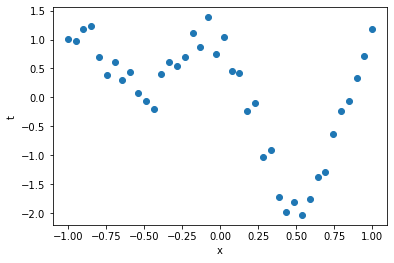

In [5]:
# Set up the data
import pylab as pl
%matplotlib inline


x = np.linspace(0,1,40).reshape((40,1))
t = np.sin(2*np.pi*x) + np.cos(4*np.pi*x) + np.random.randn(40).reshape((40,1))*0.2
x = (x-0.5)*2

# Split into training, testing, and validation sets
train = x[0::2,:]
test = x[1::4,:]
valid = x[3::4,:]
traintarget = t[0::2,:]
testtarget = t[1::4,:]
validtarget = t[3::4,:]

# Plot the data
pl.plot(x,t,'o')
pl.xlabel('x')
pl.ylabel('t')

# Perform basic training with a small MLP
import mlp
net = mlp.mlp(train,traintarget,3,outtype='linear')
net.mlptrain(train,traintarget,0.25,101)

# Use early stopping
net.earlystopping(train,traintarget,valid,validtarget,0.25)

pl.show()


## 6. Iris data set
* [Iris Data set](https://archive.ics.uci.edu/ml/datasets/Iris)

In [6]:
def preprocessIris(infile,outfile):

    stext1 = 'Iris-setosa'
    stext2 = 'Iris-versicolor'
    stext3 = 'Iris-virginica'
    rtext1 = '0'
    rtext2 = '1'
    rtext3 = '2'

    fid = open(infile,"r")
    oid = open(outfile,"w")

    for s in fid:
        if s.find(stext1)>-1:
            oid.write(s.replace(stext1, rtext1))
        elif s.find(stext2)>-1:
            oid.write(s.replace(stext2, rtext2))
        elif s.find(stext3)>-1:
            oid.write(s.replace(stext3, rtext3))
    fid.close()
    oid.close()

iris = np.loadtxt('iris_proc.data',delimiter=',')
iris[:,:4] = iris[:,:4]-iris[:,:4].mean(axis=0)
imax = np.concatenate((iris.max(axis=0)*np.ones((1,5)),np.abs(iris.min(axis=0)*np.ones((1,5)))),axis=0).max(axis=0)
iris[:,:4] = iris[:,:4]/imax[:4]
print(iris[0:5,:])

# Split into training, validation, and test sets
target = np.zeros((np.shape(iris)[0],3));
indices = np.where(iris[:,4]==0) 
target[indices,0] = 1
indices = np.where(iris[:,4]==1)
target[indices,1] = 1
indices = np.where(iris[:,4]==2)
target[indices,2] = 1

# Randomly order the data
order = list(range(np.shape(iris)[0])) ## python 3

np.random.shuffle(order)
iris = iris[order,:]
target = target[order,:]

train = iris[::2,0:4]
traint = target[::2]
valid = iris[1::4,0:4]
validt = target[1::4]
test = iris[3::4,0:4]
testt = target[3::4]

#print train.max(axis=0), train.min(axis=0)

# Train the network
import mlp
net = mlp.mlp(train,traint,5,outtype='logistic')
net.earlystopping(train,traint,valid,validt,0.1)
net.confmat(test,testt)

[[-0.36142626  0.33135215 -0.7508489  -0.76741803  0.        ]
 [-0.45867099 -0.04011887 -0.7508489  -0.76741803  0.        ]
 [-0.55591572  0.10846954 -0.78268251 -0.76741803  0.        ]
 [-0.60453809  0.03417533 -0.71901528 -0.76741803  0.        ]
 [-0.41004862  0.40564636 -0.7508489  -0.76741803  0.        ]]
1
Iteration:  0  Error:  26.344251113258487
2
Iteration:  0  Error:  0.05790259172920843
3
Iteration:  0  Error:  0.02783076947269201
Stopped 1.3616357900281568 1.2660895751191823 1.0847442036017874
Confusion matrix is:
[[ 8.  0.  0.]
 [ 0. 14.  1.]
 [ 0.  2. 12.]]
Percentage Correct:  91.8918918918919


## 7. MNIST Data Set

In [7]:
# Read the dataset in 
import pickle, gzip

f = gzip.open('mnist.pkl.gz','rb')
tset, vset, teset = pickle.load(f, encoding='iso-8859-1')
f.close()

nread = 200
# Just use the first few images
train_in = tset[0][:nread,:]

# This is a little bit of work -- 1 of N encoding
# Make sure you understand how it does it
train_tgt = np.zeros((nread,10))
for i in range(nread):
    train_tgt[i,tset[1][i]] = 1

test_in = teset[0][:nread,:]
test_tgt = np.zeros((nread,10))
for i in range(nread):
    test_tgt[i,teset[1][i]] = 1

# We will need the validation set
valid_in = vset[0][:nread,:]
valid_tgt = np.zeros((nread,10))
for i in range(nread):
    valid_tgt[i,vset[1][i]] = 1

for i in [1,2,5,10,20]:  
    print("----- "+str(i))  
    net = mlp.mlp(train_in,train_tgt,i,outtype='softmax')
    net.earlystopping(train_in,train_tgt,valid_in,valid_tgt,0.1)
    net.confmat(test_in,test_tgt)

----- 1
1
Iteration:  0  Error:  92.49740617590348
2
Iteration:  0  Error:  88.33870483663188
3
Iteration:  0  Error:  86.13594286921872
4
Iteration:  0  Error:  84.35428787267905
5
Iteration:  0  Error:  83.09373356021784
6
Iteration:  0  Error:  82.20711419418338
7
Iteration:  0  Error:  81.54275127954827
8
Iteration:  0  Error:  81.020411060574
9
Iteration:  0  Error:  80.62796147123515
10
Iteration:  0  Error:  80.33474666471676
11
Iteration:  0  Error:  80.11108189901768
12
Iteration:  0  Error:  79.93592736780386
13
Iteration:  0  Error:  79.7946151826093
14
Iteration:  0  Error:  79.67717828190635
15
Iteration:  0  Error:  79.57680241470408
16
Iteration:  0  Error:  79.48869275846363
17
Iteration:  0  Error:  79.40935229721929
18
Iteration:  0  Error:  79.33615107416972
19
Iteration:  0  Error:  79.2670993059256
20
Iteration:  0  Error:  79.20078805910713
21
Iteration:  0  Error:  79.1363462817599
22
Iteration:  0  Error:  79.07314965480317
Stopped 83.01442465695547 83.008519960